In [1]:
!pip install optuna scikit-learn seaborn scipy xgboost lightgbm joblib plotly tqdm --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from scipy.stats import spearmanr, pearsonr
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
import plotly.express as px
import os

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Конфигурация
DATA_PATH = '/content/drive/MyDrive/data_c/data_fe.csv'
SAVE_DIR = '/content/drive/MyDrive/data_c/model_results'
os.makedirs(SAVE_DIR, exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:

# Загрузка и подготовка данных
print("Загрузка данных...")
data = pd.read_csv(DATA_PATH)
print(f"Данные загружены, форма: {data.shape}")

# Определение признаков и целевых переменных
targets = ['CC50', 'pCC50']
features = [col for col in data.columns if col not in ['IC50', 'pIC50', 'CC50',
                                                       'pCC50', 'SI', 'SI_log']]

# Разделение данных
X = data[features]
y = data[targets]
X_train, X_test, y_train_df, y_test_df = train_test_split(X, y, test_size=0.2,
                                                          random_state=42)
print(f"\nРазделение данных:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)


Загрузка данных...
Данные загружены, форма: (998, 167)

Разделение данных:
Train: (798, 161), Test: (200, 161)


In [3]:

# Выбор лучшей целевой переменной
print("\nВыбор целевой переменной...")
rmse_results = {}
for target in tqdm(targets, desc="Оценка целей"):
    X_temp, X_val, y_temp, y_val = train_test_split(
        X_train_scaled,
        y_train_df[target].values,
        test_size=0.2,
        random_state=42
    )

    # Отбор признаков
    mi = mutual_info_regression(X_temp, y_temp)
    top50_idx = np.argsort(mi)[::-1][:50]
    X_tr_sel = X_temp.iloc[:, top50_idx]
    X_val_sel = X_val.iloc[:, top50_idx]

    # Оценка модели
    lr = LinearRegression()
    lr.fit(X_tr_sel, y_temp)
    y_pred = lr.predict(X_val_sel)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_results[target] = rmse

best_target = min(rmse_results, key=rmse_results.get)
print(f"\nЛучшая цель: {best_target} (RMSE: {rmse_results[best_target]:.4f})")
y_train = y_train_df[best_target].values
y_test = y_test_df[best_target].values



Выбор целевой переменной...


Оценка целей: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


Лучшая цель: pCC50 (RMSE: 3.8771)


In [4]:

# Отбор признаков ансамблевым методом
print("\nОтбор признаков...")
selector = SelectFromModel(
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    max_features=50
)
selector.fit(X_train_scaled, y_train)
best_idx = selector.get_support(indices=True)
selected_features = [features[i] for i in best_idx]

print("\nТоп-10 отобранных признаков:")
for i, feature in enumerate(selected_features[:10]):
    print(f"{i+1}. {feature}")

# Подготовка финальных данных
X_train_final = X_train_scaled[selected_features]
X_test_final = X_test_scaled[selected_features]
print(f"\nФинальная размерность: {X_train_final.shape[1]} признаков")



Отбор признаков...

Топ-10 отобранных признаков:
1. MaxAbsEStateIndex
2. MinAbsEStateIndex
3. MinEStateIndex
4. qed
5. MolWt
6. MaxPartialCharge
7. MinPartialCharge
8. FpDensityMorgan1
9. BCUT2D_MWHI
10. BCUT2D_MWLOW

Финальная размерность: 50 признаков


In [5]:

# Сравнение моделей
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GB': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=42, n_jobs=-1)
}

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    r, _ = pearsonr(y_test, pred)

    return rmse, mae, r2, r

print("\nСравнение моделей:")
metrics = {}
for name, model in tqdm(models.items(), desc="Обучение моделей"):
    rmse, mae, r2, r = evaluate_model(model, X_train_final, y_train,
                                      X_test_final, y_test, name)
    metrics[name] = (rmse, mae, r2, r)
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, Pearsonr={r:.4f}")



Сравнение моделей:


Обучение моделей:  14%|█▍        | 1/7 [00:00<00:01,  5.96it/s]

Linear: RMSE=3.4364, MAE=2.7917, R²=0.3409, Pearsonr=0.5858
Ridge: RMSE=3.4361, MAE=2.7934, R²=0.3410, Pearsonr=0.5858
Lasso: RMSE=3.5701, MAE=2.9834, R²=0.2886, Pearsonr=0.5417


Обучение моделей:  57%|█████▋    | 4/7 [00:04<00:03,  1.21s/it]

RF: RMSE=3.1576, MAE=2.2820, R²=0.4435, Pearsonr=0.6720


Обучение моделей:  71%|███████▏  | 5/7 [00:08<00:04,  2.09s/it]

GB: RMSE=3.1848, MAE=2.3668, R²=0.4339, Pearsonr=0.6630


Обучение моделей:  86%|████████▌ | 6/7 [00:25<00:06,  6.30s/it]

XGBoost: RMSE=3.3117, MAE=2.2873, R²=0.3879, Pearsonr=0.6474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10254
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -9.192238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Обучение моделей: 100%|██████████| 7/7 [00:30<00:00,  4.36s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM: RMSE=3.0573, MAE=2.1637, R²=0.4783, Pearsonr=0.7027


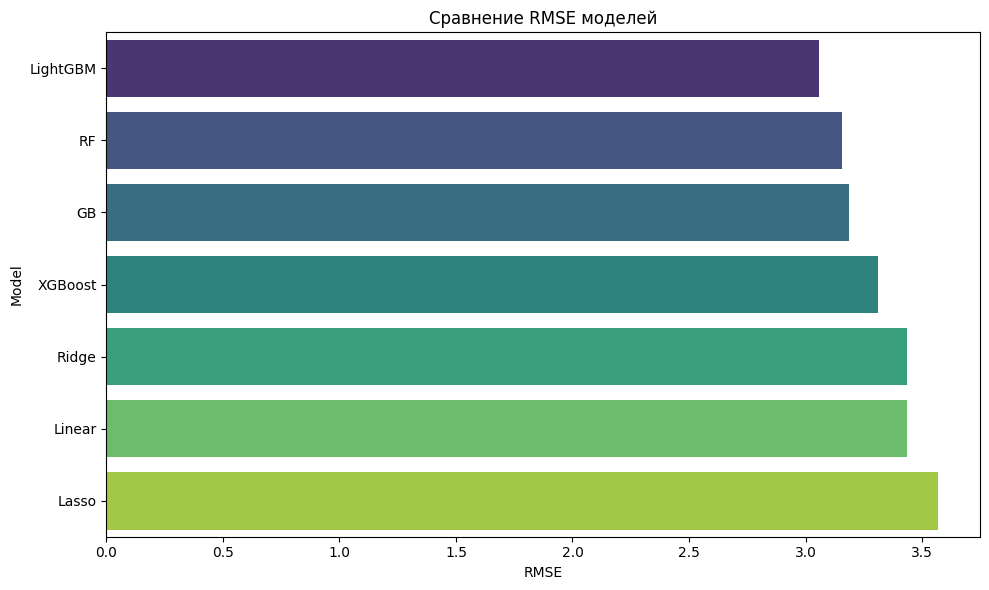


Лучшая модель: LightGBM (RMSE: 3.0573)


In [6]:

# Визуализация сравнения
rmse_df = pd.DataFrame({
    'Model': list(metrics.keys()),
    'RMSE': [metrics[name][0] for name in metrics]
}).sort_values('RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Model', data=rmse_df, palette='viridis')
plt.title('Сравнение RMSE моделей')
plt.tight_layout()
plt.savefig(f'{SAVE_DIR}/model_comparison.png')
plt.show()

best_model_name = rmse_df.iloc[0]['Model']
best_base = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} (RMSE: {rmse_df.iloc[0]['RMSE']:.4f})")


In [7]:

# Оптимизация гиперпараметров Optuna
def get_param_func(name):
    if name == 'Ridge':
        return lambda t: {'alpha': t.suggest_float('alpha', 0.01, 100, log=True)}
    if name == 'Lasso':
        return lambda t: {'alpha': t.suggest_float('alpha', 0.01, 100, log=True)}
    if name == 'RF':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 5, 50),
            'min_samples_split': t.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 10),
            'max_features': t.suggest_categorical('max_features', ['sqrt', 'log2', 0.8]),
            'random_state': 42,
            'n_jobs': -1
        }
    if name == 'GB':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 10),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.2, log=True),
            'subsample': t.suggest_float('subsample', 0.5, 1.0),
            'min_samples_leaf': t.suggest_int('min_samples_leaf', 1, 10),
            'random_state': 42
        }
    if name == 'XGBoost':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 12),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': t.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': t.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': t.suggest_float('gamma', 0, 1),
            'reg_alpha': t.suggest_float('reg_alpha', 0, 1),
            'random_state': 42,
            'n_jobs': -1
        }
    if name == 'LightGBM':
        return lambda t: {
            'n_estimators': t.suggest_int('n_estimators', 100, 1000),
            'max_depth': t.suggest_int('max_depth', 3, 15),
            'learning_rate': t.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': t.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': t.suggest_float('colsample_bytree', 0.6, 1.0),
            'num_leaves': t.suggest_int('num_leaves', 20, 200),
            'min_child_samples': t.suggest_int('min_child_samples', 5, 50),
            'reg_alpha': t.suggest_float('reg_alpha', 0, 1),
            'random_state': 42,
            'n_jobs': -1
        }
    return None

param_func = get_param_func(best_model_name)

if best_model_name not in ['Linear'] and param_func is not None:
    print(f"\nОптимизация {best_model_name} с Optuna...")

    def objective(trial):
        params = param_func(trial)
        ModelClass = type(best_base)
        model = ModelClass(**params)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for tr_idx, val_idx in kf.split(X_train_final):
            X_tr, y_tr = X_train_final.iloc[tr_idx], y_train[tr_idx]
            X_val, y_val = X_train_final.iloc[val_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)
            val_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            scores.append(rmse)

        return np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nЛучшие гиперпараметры:")
    for k, v in study.best_params.items():
        print(f"{k}: {v}")
    print(f"Лучшее значение RMSE: {study.best_value:.4f}")

    # Обучение финальной модели
    ModelClass = type(best_base)
    optimized = ModelClass(**study.best_params)
    optimized.fit(X_train_final, y_train)

    # Кросс-валидация
    cv_scores = cross_val_score(
        optimized,
        X_train_final,
        y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse = -cv_scores.mean()
    print(f"Cross-Validation RMSE: {cv_rmse:.4f} (±{-cv_scores.std():.4f})")

    # Оценка на тесте
    test_pred = optimized.predict(X_test_final)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    print(f"Тестовый RMSE: {test_rmse:.4f}")

    # Ансамблирование
    print("\nСоздание ансамбля из 5 моделей...")
    ensemble_preds = []
    for i in tqdm(range(5), desc="Обучение ансамбля"):
        model = ModelClass(**study.best_params)
        model.set_params(**{'random_state': 42 + i})
        model.fit(X_train_final, y_train)
        pred_i = model.predict(X_test_final)
        ensemble_preds.append(pred_i)

    ensemble_pred = np.mean(ensemble_preds, axis=0)
    ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    print(f"RMSE ансамбля: {ensemble_rmse:.4f}")

    final_pred = ensemble_pred
    final_rmse = ensemble_rmse
else:
    print("\nОптимизация не требуется")
    optimized = best_base
    optimized.fit(X_train_final, y_train)
    final_pred = optimized.predict(X_test_final)
    final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))


[I 2025-06-18 00:26:19,656] A new study created in memory with name: no-name-d011eb04-eccf-4129-8c69-065db4326e28



Оптимизация LightGBM с Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Обучение ансамбля:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10254
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -9.192238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Обучение ансамбля:  20%|██        | 1/5 [00:02<00:08,  2.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Обучение ансамбля:  40%|████      | 2/5 [00:04<00:06,  2.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10254
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -9.192238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Обучение ансамбля:  60%|██████    | 3/5 [00:06<00:04,  2.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10254
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -9.192238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Обучение ансамбля:  80%|████████  | 4/5 [00:09<00:02,  2.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10254
[LightGBM] [Info] Number of data points in the train set: 798, number of used features: 50
[LightGBM] [Info] Start training from score -9.192238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Обучение ансамбля: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

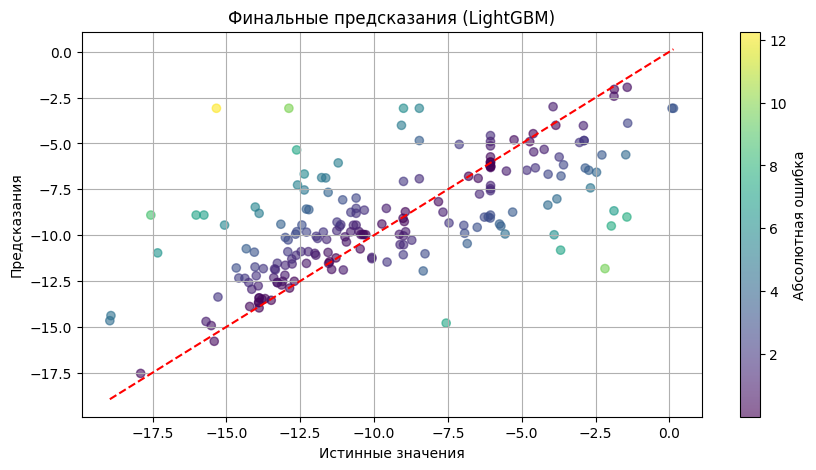

In [8]:

# Финальная визуализация
plt.figure(figsize=(10, 5))
plt.scatter(y_test, final_pred, alpha=0.6, c=np.abs(y_test - final_pred), cmap='viridis')
plt.colorbar(label='Абсолютная ошибка')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.title(f'Финальные предсказания ({best_model_name})')
plt.grid(True)
plt.savefig(f'{SAVE_DIR}/final_predictions.png')
plt.show()


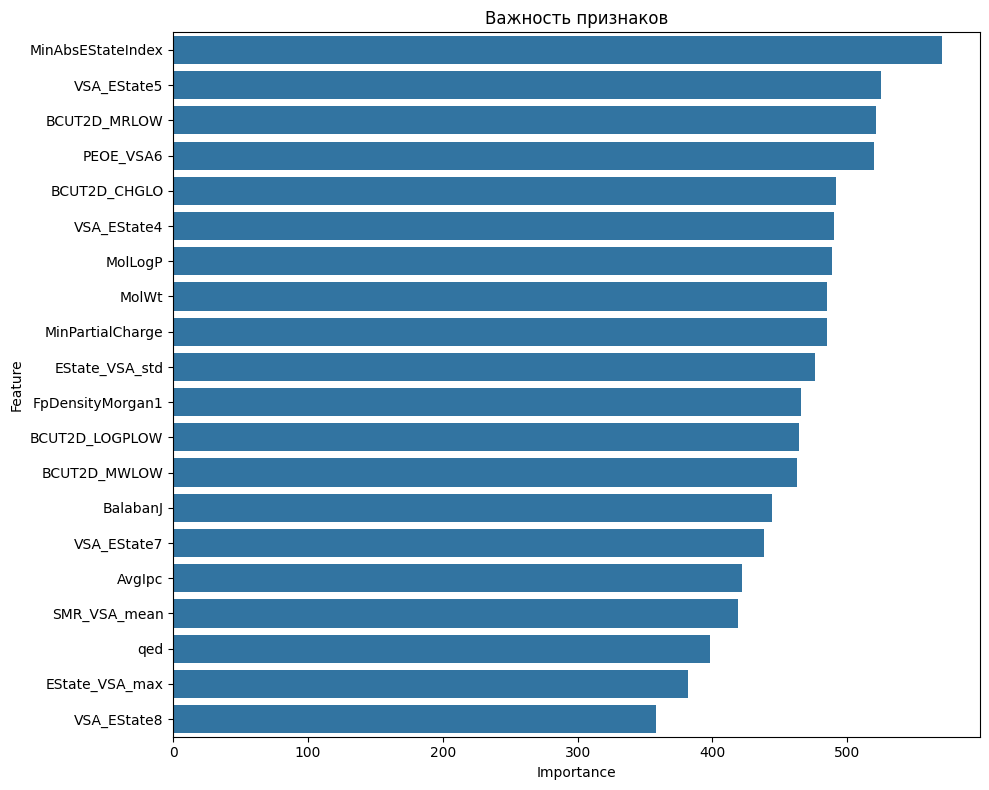

In [9]:

# Анализ важности признаков
if hasattr(optimized, 'feature_importances_'):
    importances = optimized.feature_importances_
    feat_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Топ-20 признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_importance.head(20))
    plt.title('Важность признаков')
    plt.tight_layout()
    plt.savefig(f'{SAVE_DIR}/feature_importance.png')
    plt.show()

    # Интерактивная визуализация
    fig = px.bar(feat_importance.head(20), x='Importance', y='Feature', orientation='h')
    fig.write_html(f'{SAVE_DIR}/feature_importance.html')

    feat_importance.to_csv(f'{SAVE_DIR}/feature_importance.csv', index=False)


In [10]:

# Анализ ошибок
errors = y_test - final_pred
max_error_idx = np.argsort(np.abs(errors))[::-1][:10]
error_df = pd.DataFrame({
    'True Value': y_test[max_error_idx],
    'Predicted Value': final_pred[max_error_idx],
    'Error': errors[max_error_idx]
}, index=y_test_df.index[max_error_idx])

print("\nСоединения с наибольшими ошибками:")
display(error_df)



Соединения с наибольшими ошибками:


,True Value,Predicted Value,Error
798,-15.337991,-3.081487,-12.256505
792,-12.883802,-3.081487,-9.802315
266,-2.181571,-11.823577,9.642006
809,-17.558023,-8.903674,-8.654350
351,-1.438755,-9.009671,7.570916
595,-1.967153,-9.498886,7.531732
307,-12.621941,-5.352704,-7.269237
319,-7.558558,-14.795881,7.237322
294,-3.683363,-10.817630,7.134267
814,-16.023830,-8.903674,-7.120156


In [11]:

# Сохранение полных результатов
results_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': final_pred,
    'Error': errors
}, index=y_test_df.index)

results_df.to_csv(f'{SAVE_DIR}/predictions_{best_target}_{best_model_name}.csv')
print(f"\nРезультаты сохранены в {SAVE_DIR}")



Результаты сохранены в /content/drive/MyDrive/data_c/model_results


In [12]:

print("\nФинальный отчет:")
print(f"Целевая переменная: {best_target}")
print(f"Лучшая модель: {best_model_name}")
print(f"Финальный RMSE: {final_rmse:.4f}")
print(f"R²: {r2_score(y_test, final_pred):.4f}")
print(f"Pearsonr: {pearsonr(y_test, final_pred)[0]:.4f}")


Финальный отчет:
Целевая переменная: pCC50
Лучшая модель: LightGBM
Финальный RMSE: 3.1254
R²: 0.4548
Pearsonr: 0.6812
